In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import integrate, optimize
import time
from tqdm import tqdm
from matplotlib import animation
from IPython.display import HTML
import seaborn as sns

In [2]:
%matplotlib inline

# Cellular Automata S.I.R. Model

### Description

Based on the reference [paper](https://www.math.uh.edu/~zpkilpat/teaching/math4309/project/physa99_fuentes.pdf), the aim of the project is to simulate and then study the evolution of Susceptible-Infected-Removed populations over space and time.

### Assignments
1. Consider a grid of a given form (squared or exagonal or whatever) and then let propagate the SIR model. 
2. Repeat point 1 several times in order to obtain several reference datasets
3. Try to predict the evolution of the epidemic both in space and time on the basis of the previous steps, e.g. by means of 
4. Define a metric on how the epidemic evolved e.g. assigning a probability for a given node not to get infected or predict the fraction of the nodes that got infected at the end of the epidemic

### Contacts
* Leonardo Badia <badia@dei.unipd.it>

# SIR Model and Cellular Automata introduction

In the following project will be analized the $ SIR $ model for the evolution of infectivity nucleus inside a finite population exploiting Cellular Automata technique.
### SIR Model
An infection which is transmitted from person to person and the overall population sampled is divided into three groups: 
* Susceptibles: containing the individuals that have not yet been infected and still can contract the infection; 
* Infected: that represents the individuals that are currently infected and that are able to infect other people;
* Removed, that are all the individuals that recovered from the illness and are now immune, and also people who died due to the infection.

SIR models are theoretically described by partial differential equations:

$$
    \frac{dS}{dt} = -\lambda SI + \mu - \mu S;
$$

$$
    \frac{dI}{dt} = \lambda SI -\gamma I -\mu I;
$$

$$
    \frac{dR}{dt} = \gamma I - \mu R;
$$

where $\lambda$ is a parameter describing the rate of interactions between susceptibles and infectious, $\gamma$ is the recovery rate and $\mu$ is a parameter related to vital dynamics of the population (birth-death rate).

### Cellular Automata
An alternative approach, which provides much better efficiency in terms of computational time is by using Cellular Automata, that is a discrete time approach using matrices whose elements are configured in networks.

Every element of the matrix is assigned a value describing its epidemiological state (S=0, I=1, R=-1) which changes with respect to the states of neighbor elements, according to a fixed range.

The change of state from S to I depends, just as for the differential equation model, on the interaction between an infected element and its neighbors, which is based on a infection probability $p_i$.

Once infected, the element recovers after a fixed number of iterations representing the total recovery time (which takes into account incubation, proper infection and latency times). In this case the vital dynamics are not considered ($\mu=0$), so the equations governing the epidemic become:
$$
    \frac{dS}{dt} = -\lambda SI ;
$$

$$
    \frac{dI}{dt} = \lambda SI -\gamma I ;
$$

$$
    \frac{dR}{dt} = \gamma I;
$$

Eventually thanks to Cellular Automata several and efficient simulations of an epidemiological spread can be performed, allowing to obtain accurate predictions in time and space.


# Functions

In [3]:
def draw_line(mat, point1, point2):
    """
        function that draws the best possible line (made of 0s) between two points point1, point2
    """
    x0, y0 = point1[0], point1[1];
    x1, y1 = point2[0], point2[1];
    if not (0 <= x0 < mat.shape[0] and 0 <= x1 < mat.shape[0] and
            0 <= y0 < mat.shape[1] and 0 <= y1 < mat.shape[1]):
        raise ValueError('Invalid coordinates.')
        
    if (x0, y0) == (x1, y1):
        mat[x0, y0] = 0
        return mat
    
    # Swap axes if Y slope is smaller than X slope
    transpose = abs(x1 - x0) < abs(y1 - y0)
    if transpose:
        mat = mat.T
        x0, y0, x1, y1 = y0, x0, y1, x1
        
    # Swap line direction to go left-to-right if necessary
    if x0 > x1:
        x0, y0, x1, y1 = x1, y1, x0, y0
        
    # Compute intermediate coordinates using line equation
    x = np.arange(x0 + 1, x1)
    y = np.round(((y1 - y0) / (x1 - x0)) * (x - x0) + y0).astype(x.dtype)
    
    # Write intermediate coordinates
    mat[x, y] = 0

    return mat if not transpose else mat.T

    
def new_population(N, n_vertices):
    """
        function that generates a new population. A population is a matrix NxN containing 2 everywhere except
        inside a figure of n_vertices vertices where there are all 0s.
    """
    from numpy import pi, floor, ceil, cos, sin;
    
    if n_vertices < 3: raise Exception('The number of vertices must be greater than 2.');
    
    if N%2 == 0: N+=1
        
    M = np.ones((N,N), dtype=int)+1 # matrix of 2s

    center = [floor(N/2), floor(N/2)]
    radius = floor(N/2)
    angle = 2*pi/n_vertices
    
    vertices = np.zeros((n_vertices+1,2), dtype=int)
    for vertex in range(n_vertices): # for each vertex of the polygon
        x = int(floor(center[0] + radius*cos(vertex*angle))) # x coord of the vertex of the polygon
        y = int(floor(center[1] - radius*sin(vertex*angle))) # y coord of the vertex of the polygon
        M[x,y] = 0 # set to 0 the coordinate of the population matrix
        vertices[vertex] = [x,y] # list of coordinates of the vertices of the polygon
    vertices[n_vertices] = vertices[0] # add the first vertex at the end so that is a closed polygon

    for i in range(1,len(vertices)):
        M = draw_line(M, vertices[i-1], vertices[i]) # trace the edges of the polygon
            
       
    for row in range(N): # the polygon is filled with 0s for each row
        row_i = M[row,:]   
        x1 = np.argwhere(M[row,:]==0)
        x2 = np.argwhere(M[row,:]==0)
        if len(x1)==0 or len(x2)==0: continue;
        x1, x2 = min(x1), max(x2)
        if x1==0 and x2==0: continue;
        M = draw_line(M, [row, x1], [row, x2])
          
    return M;

def inizialization(population, infected, patients_0_nr=0, radius=0, random=False):
    """
        Inizialization for patients zero, if random = True takes patients_0_nr random points inside
        a centered radius else takes coordinates
    """
    centered = False
    center = int(np.floor(population.shape[0]/2))
    if not random:
        for coord in infected:
            if population[coord] == 2 : raise Exception('Bad inizialization, outside polygon');
            population[coord] = 1 # the people located at "infected" are turned into infected: 0 -> 1
    else:
        #we grab the indexes of the ones
        if centered:
            mask = np.ones((population.shape[0], population.shape[1]))
            mask[center-radius:center+radius, center-radius:center+radius]=0
            x,y = np.where(mask+population == 0)
            
        x,y = np.where(population == 0)
        #we chose one index randomly
        i = np.random.randint(len(x),size=patients_0_nr)
        for randnr in i:
            coord = (x[i],y[i])
            population[coord] = 1
    return population


# Tunable Parameters

* Susceptible $S \rightarrow 0$
* Infected $I \rightarrow 1$
* Recovered $R \rightarrow -1$
$\newline$
* cycles: lifetime of every experiment.
* experiments: number of experiments.
* resolution: $resolution^2$ is the number of nodes inside the outward matrix. The number of useful nodes for the experiment will be always $<resolution$. Increasing this value will make computational time increase rapidly.
* polygon_sides: the number of sides for the polygon ($3\rightarrow$triangle, $4\rightarrow$square, ...).
* p_i: probability for a node to get infected and change status from $S$ to $I$.
* t_r: time of recovery before an infected node changes status from $I$ to $R$.
* patients_0_nr: number of patients zero at the beginning of the simulation.
* radius: centered radius inside where the patients zero will be spawned randomly.

In [4]:
cycles = 100 # maximum number of cycles, stop time
experiments = 50 # number of experiments
resolution, polygon_sides = 150, 7 # (resolution)^2 is in reality the number of people inside the outward matrix
p_i = 0.5 # probability of infection
t_r = 3 # time of recovery
patients_0_nr, radius = 10, 25 # number of patients zero at the beginning of the simulation inside a radius of value "radius"

# 1-2. Algorithm

The algorithm developed is based on the reference paper method. This replicates the propagation of the virus through the first-order neighbourhood since also in the paper they never go beyond. This propagation is slightly different from the original since some parameters are not so clear, in particular the random variable $h$ that discriminates the infection and the formula for obtaining $u_{i,j}$. The first parameter has a value from 0 to 1 but has a probability distribution p(h)=1, which has no clear meaning and hasn’t an extensive explanation. The formula instead has a strange normalization behaviour that makes it difficult to imagine how are the values in the experiment and so the meaning of $u_{i,j}$ and the conditions of infection. For this reason, we developed our version that is different but has the same behaviour. The algorithm cycles over all the elements in the matrix and, if it encounters an infected one, it explores the neighbours to infect them, with a probability $p_i$ for everyone. The elements infected in the actual cycle are skipped and considered in the next. In this way, the probability of being infected is proportional to the number of infected neighbours. The recovery instead is done as the original article, since an infected recovers in $t_r$ iterations. In this way,  the complexity of the algorithm results in the number of maximum cycles multiplied by the number of the matrix elements. Each of these iterations performs a constant number of operations. This makes the algorithm efficient for this type of problem.

In order to build an efficient estimation from the simulations, an useful tool will be the list DF_List, which will be used later in order to have an average of all the experiments at time $t$ (Building process in the image).

<img src="DFList.png" width="800">

In [5]:
df_experiments = pd.DataFrame(columns = ['EXP','S','I','R'])
df_S = pd.DataFrame(columns=np.arange(cycles+1))
df_I = pd.DataFrame(columns=np.arange(cycles+1))
df_R = pd.DataFrame(columns=np.arange(cycles+1))

df_list_temp=[]
# initialize a list of length 'cycles' containing matrices of 50 (default initialisation value, random value different from -1,0,1,2)
for cycle in range(cycles):
    zero_mat = np.full((np.size(new_population(resolution, polygon_sides)),experiments), 50)
    # each matrix of the list refers to the i-th cycle, and the e-th column (e=0:9) contains the i-th population matrix vectorized for every experiment
    df_list_temp.append(zero_mat)
    
for experiment in tqdm(range(experiments)):
    population = new_population(resolution, polygon_sides); # population is a matrix of 2 if outside the figure while 0 if inside the figure
    population_time = np.zeros(population.shape)-1

    center = int(np.floor(resolution/2)) # just to keep track of where the center is

    infected = [(center,center)] # initialization of where Infected are. Can be tuple or list of tuples
    population = inizialization(population, infected, patients_0_nr, radius, random=True)
    S=[]; I=[]; R=[]; 
    for cycle in range(cycles):
        s,i,r=0,0,0
        for index,value in np.ndenumerate(population):
            if population_time[index]==cycle:pass #already processed
            elif value==2:pass #not in the region space
            elif value==1: #infect detected
                i+=1
                #cycle the neighbors for infection
                for j in range(-1,2):
                    for k in range(-1,2):
                        if 0<=index[0]+j<population.shape[0] and 0<=index[1]+k<population.shape[1]:
                            if population[index[0]+j,index[1]+k]==0 and np.random.choice([1, 0], p=[p_i, 1-p_i]): #element get infected
                                population[index[0]+j,index[1]+k]=1
                                population_time[index[0]+j,index[1]+k]=cycle #mark as infected in this cicle
                                if j==1 or (j==0 and k==1): s+=1 #the item will not be counted otherwise
                #infected recovers after t_r cycles
                if cycle-population_time[index]>=t_r:
                #if np.random.choice([1, 0], p=[p_r*(cycle-population_time[index]), 1-p_r*(cycle-population_time[index])]):
                #if np.random.choice([1, 0], p=[p_r, 1-p_r]):
                    population[index]=-1
                    population_time[index]=cycle
            elif value==0: s+=1
            elif value==-1: r+=1
        S.append(s) # number of S in cycle
        I.append(i) # number of I in cycle
        R.append(r) # number of R in cycle
        df_list_temp[cycle][:,experiment] = population.flatten() #write the current vectorized population matrix in the correspondant place of the matrix list

        if i==0: break 

    s,i,r=0,0,0
    for index,value in np.ndenumerate(population):
        if value==1: i+=1
        elif value==0: s+=1
        elif value==-1: r+=1
    S.append(s) # number of S in last cycle
    I.append(i) # number of I in last cycle
    R.append(r) # number of R in last cycle
    S = np.concatenate((np.array(S),np.full(cycles-len(S)+1,S[len(S)-1])), axis=0)
    I = np.concatenate((np.array(I),np.full(cycles-len(I)+1,I[len(I)-1])), axis=0)
    R = np.concatenate((np.array(R),np.full(cycles-len(R)+1,R[len(R)-1])), axis=0)
    df_S = df_S.append(pd.DataFrame(S).T)
    df_I = df_I.append(pd.DataFrame(I).T)
    df_R = df_R.append(pd.DataFrame(R).T)
    
    DF_List=[] # final list with dataframe for each performed cycle, for every experiment
    for cycle in range(cycles):
        df_cycle=pd.DataFrame(df_list_temp[cycle])
        DF_List.append(df_cycle)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [02:46<00:00,  3.34s/it]


In [6]:
df_S.to_csv(r'S.csv', index = False)
df_I.to_csv(r'I.csv', index = False)
df_R.to_csv(r'R.csv', index = False)

In [7]:
df_S = pd.read_csv(r'S.csv')
df_I = pd.read_csv(r'I.csv')
df_R = pd.read_csv(r'R.csv')

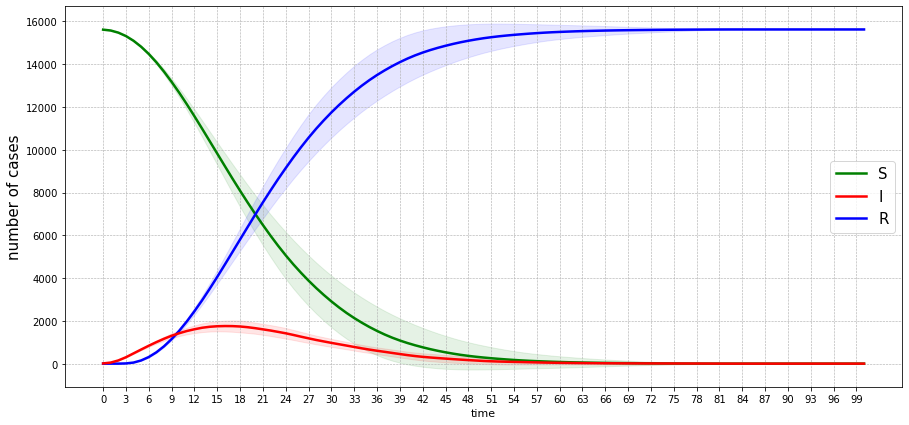

In [8]:
# graph of the number of cases for each cycle
fig2 = plt.figure(figsize = (15,7))

plt.plot(df_S.mean(), label='S', zorder=10, linewidth=2.5, color='green');
plt.plot(df_I.mean(), label='I', zorder=20, linewidth=2.5, color='red');
plt.plot(df_R.mean(), label='R', zorder=10, linewidth=2.5, color='blue');

plt.fill_between(np.arange(cycles+1),df_S.mean()-df_S.std(), df_S.mean()+df_S.std(), color='green', alpha=0.1)
plt.fill_between(np.arange(cycles+1),df_I.mean()-df_I.std(), df_I.mean()+df_I.std(), color='red', alpha=0.1)
plt.fill_between(np.arange(cycles+1),df_R.mean()-df_R.std(), df_R.mean()+df_R.std(), color='blue', alpha=0.1)

plt.xlabel('time', fontsize=11);
plt.ylabel('number of cases', fontsize=15);
plt.legend(fontsize=15);
plt.grid(linestyle="--", linewidth=0.6, zorder=-10);
plt.xticks(np.arange(0, cycles+1, 3));

# 3. Space prediction
In order to obtain a prediction on space, at each time $t_i$ a sum between all the experiments is performed. Then, every "average experiment" (sum of all the experiments) is summed up to time $t_n$:

$$
\Phi = \sum_{i=0}^{n} \sum_{j=0}^{m} I(t_i, exp_j)
$$

which, normalized, gives the percentage of times a given node got infected in a mean experiment:

$$
p_\% = \frac{\Phi}{max(\Phi)}
$$

If $m$ sufficiently large (i.e: number of experiments $m>>0$) the Law of Large Numbers (LLN) can be exploited to obtain a probability for a given node to get infected (A node can be seen as a Random Variable with probability of getting infected $p_i$):

(LLN)
$X_1, X_2, ..., X_n$ infinite sequence of i.i.d. random variables with expected value $E(X_1) = E(X_2) = ...= \mu$. 
The sample average
$$
\bar{X}_n=\frac{1}{n}(X_1+...+X_n) \longrightarrow \mu \text{ as } n\longrightarrow\infty
$$

and in this case the higher $m$ the more $p_\%$ resembles a probability distribution with respect to space, as it gets closer and closer to the mean value which corresponds also to the true value.
$$
p_\% \longrightarrow P(node=I)\text{ , as number of experiments }\longrightarrow \infty
$$

Note that $\Phi$ can be calculated for $I$ (Infected) as for $S$ (Susceptibles) and $R$ (Recovered).



### Infected $I$

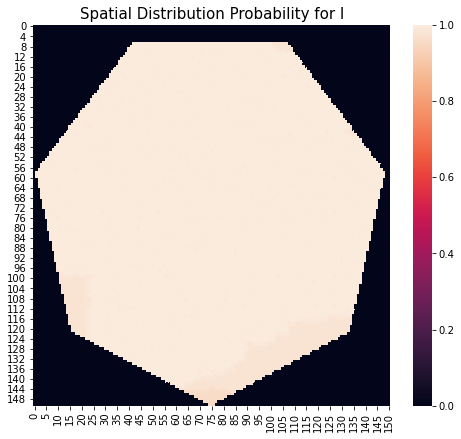

In [9]:
Space_Pred_Prob_I = pd.Series(np.zeros(np.size(population)))
for i in range(cycles-30):
    Space_Pred_Prob_I += (DF_List[i] == 1).sum(axis=1)

Space_Pred_Prob_I = Space_Pred_Prob_I/max(Space_Pred_Prob_I)

plt.figure(figsize=(8, 7));
plt.title('Spatial Distribution Probability for I', fontsize=15);
sns.heatmap(pd.DataFrame(Space_Pred_Prob_I.to_numpy().reshape((population.shape[0],population.shape[1]))));

### Susceptible $S$

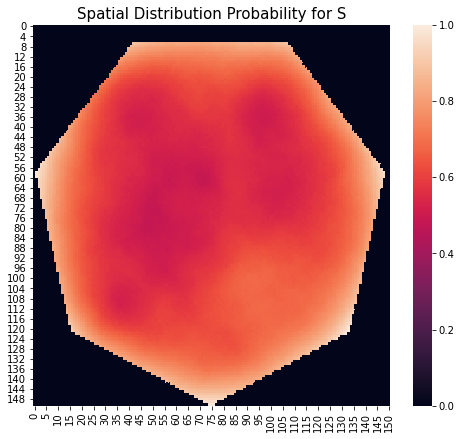

In [10]:
Space_Pred_Prob_S = pd.Series(np.zeros(np.size(population)))
for i in range(cycles):
    Space_Pred_Prob_S += (DF_List[i] == 0).sum(axis=1)

Space_Pred_Prob_S = Space_Pred_Prob_S/max(Space_Pred_Prob_S)

plt.figure(figsize=(8, 7));
plt.title('Spatial Distribution Probability for S', fontsize=15);
sns.heatmap(pd.DataFrame(Space_Pred_Prob_S.to_numpy().reshape((population.shape[0],population.shape[1]))));

### Recovered $R$

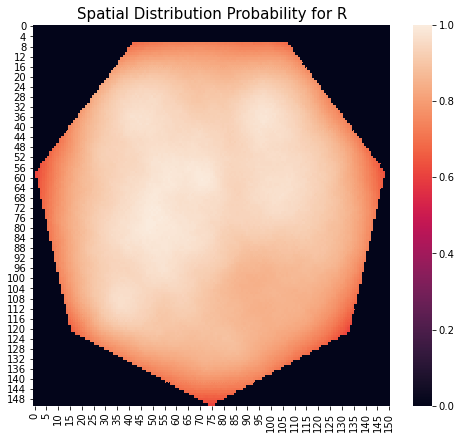

In [11]:
Space_Pred_Prob_R = pd.Series(np.zeros(np.size(population)))
for i in range(cycles):
    Space_Pred_Prob_R += (DF_List[i] == -1).sum(axis=1)

Space_Pred_Prob_R = Space_Pred_Prob_R/max(Space_Pred_Prob_R)

plt.figure(figsize=(8, 7));
plt.title('Spatial Distribution Probability for R', fontsize=15);
sns.heatmap(pd.DataFrame(Space_Pred_Prob_R.to_numpy().reshape((population.shape[0],population.shape[1]))));

# 3. Time prediction: fit empirical data to SIR Model

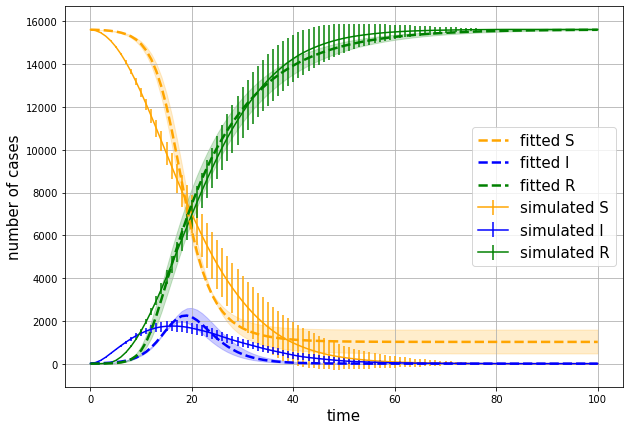

In [12]:
Training_set_size = cycles*2//3
norm = max(df_S.mean()[0:Training_set_size]+df_I.mean()[0:Training_set_size]+df_R.mean()[0:Training_set_size])
ydataI = np.array(df_I.mean()[0:Training_set_size])/norm
ydataS = np.array(df_S.mean()[0:Training_set_size])/norm
ydataR = np.array(df_R.mean()[0:Training_set_size])/norm
xdata = np.arange(Training_set_size)

def sir_model(y, x, _lambda, gamma):
    S = -_lambda * y[0] * y[1]
    R = gamma * y[1]
    I = -(S + R)
    return S, I, R

def fit_odeintI(x, _lambda, gamma):
    return integrate.odeint(sir_model, (S0, I0, R0), x, args=(_lambda, gamma))[:,1]

def fit_odeintS(x, _lambda, gamma):
    return integrate.odeint(sir_model, (S0, I0, R0), x, args=(_lambda, gamma))[:,0]

def fit_odeintR(x, _lambda, gamma):
    return integrate.odeint(sir_model, (S0, I0, R0), x, args=(_lambda, gamma))[:,2]

I0 = ydataI[0]
S0 = 1 - I0
R0 = 0.0

poptI, pcovI = optimize.curve_fit(fit_odeintI, xdata, ydataI)
poptS, pcovS = optimize.curve_fit(fit_odeintS, xdata, ydataS)
poptR, pcovR = optimize.curve_fit(fit_odeintR, xdata, ydataR)

xdata = np.arange(cycles+1)
fittedI = fit_odeintI(xdata, *poptI)
fittedS = fit_odeintS(xdata, *poptS)
fittedR = fit_odeintR(xdata, *poptR)

poptI_h = poptI + 3*np.diag(pcovI)**0.5 #error as normal distribution --> 3 sigma = 99.73% confidence
poptI_l = poptI - 3*np.diag(pcovI)**0.5
fittedI_h = fit_odeintI(xdata, *poptI_h)*norm
fittedI_l = fit_odeintI(xdata, *poptI_l)*norm

poptS_h = poptS + 3*np.diag(pcovS)**0.5
poptS_l = poptS - 3*np.diag(pcovS)**0.5
fittedS_h = fit_odeintS(xdata, *poptS_h)*norm
fittedS_l = fit_odeintS(xdata, *poptS_l)*norm

poptR_h = poptR + 3*np.diag(pcovR)**0.5
poptR_l = poptR - 3*np.diag(pcovR)**0.5
fittedR_h = fit_odeintR(xdata, *poptR_h)*norm
fittedR_l = fit_odeintR(xdata, *poptR_l)*norm


fitted_S = fittedS*norm
fitted_I = fittedI*norm
fitted_R = fittedR*norm
fig3 = plt.figure(figsize = (10,7))

# plot of the fitted model
plt.plot(fitted_S, label='fitted S', zorder=20, linewidth=2.5, linestyle='--', color='orange')
plt.fill_between(xdata, fittedS_l,fittedS_h, color='orange', alpha=0.2)
plt.plot(fitted_I, label='fitted I', zorder=20, linewidth=2.5, linestyle='--', color='blue')
plt.fill_between(xdata, fittedI_l,fittedI_h, color='blue', alpha=0.2)
plt.plot(fitted_R, label='fitted R', zorder=20, linewidth=2.5, linestyle='--', color='green')
plt.fill_between(xdata, fittedR_l, fittedR_h, color='green', alpha=0.2)

#plot of the simulated model
plt.errorbar(xdata, df_S.mean(), df_S.std(), linestyle='-', marker='', color='orange', label='simulated S')
plt.errorbar(xdata, df_I.mean(), df_I.std(), linestyle='-', marker='', color='blue', label='simulated I')
plt.errorbar(xdata, df_R.mean(), df_R.std(), linestyle='-', marker='', color='green', label='simulated R')
plt.xlabel('time', fontsize=15)
plt.ylabel('number of cases', fontsize=15)
plt.legend(fontsize=15)
plt.grid()
plt.show()

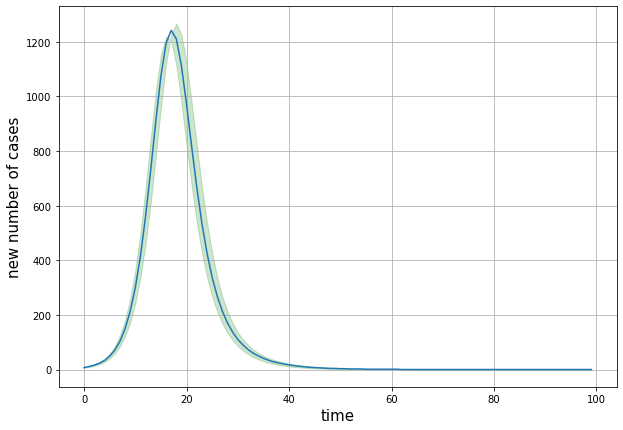

In [13]:
new_I = np.append(np.zeros(1),fitted_S[0:len(fitted_S)-1])-fitted_S
new_I_l = np.append(np.zeros(1),fittedS_l[0:len(fittedS_l)-1])-fittedS_l
new_I_h = np.append(np.zeros(1),fittedS_h[0:len(fittedS_h)-1])-fittedS_h

fig3 = plt.figure(figsize = (10,7))
plt.plot(np.round(new_I)[1:])
plt.fill_between(xdata[:cycles], new_I_l[1::], new_I_h[1::], color='green', alpha=0.2)
plt.xlabel('time', fontsize=15)
plt.ylabel('new number of cases', fontsize=15)
#plt.legend(fontsize=15)
plt.grid()

In [14]:
# Predict at t
t = 20
print("Prediction at t={}".format(t))
print("S: {}+-{}".format(round(fitted_S[t]), round(abs(fitted_S[t]-fittedS_l[t]))))
print("I: {}+-{}".format(round(fitted_I[t]), round(abs(fitted_I[t]-fittedI_l[t]))))
print("R: {}+-{}".format(round(fitted_R[t]), round(abs(fitted_R[t]-fittedR_l[t]))))

Prediction at t=20
S: 6193+-638
I: 2177+-429
R: 7471+-779


# 4. Prediction at the end of the epidemic

The time prediction is helpful to estimate the number of cases during the pandemic. For example, since it has a bell shape, the maximum number of simultaneous infects can be estimated. Also the total number can be estimated.

In [15]:
print("According to predictions, during the epidemic there will be maximum {}+-{} infected simultaneously.".format(round(max(fitted_I)), round(abs(fitted_I[np.argmax(fitted_I)]-fittedI_l[np.argmax(fitted_I)]))))
print("Instead, the total number of infected at the end of the epidemic will be: {}+-{}.".format(round(sum(new_I[1:])), np.argmax(np.round(abs(new_I-new_I_l)))))

According to predictions, during the epidemic there will be maximum 2249+-341 infected simultaneously.
Instead, the total number of infected at the end of the epidemic will be: 14599+-22.


# Animation of the Evolution

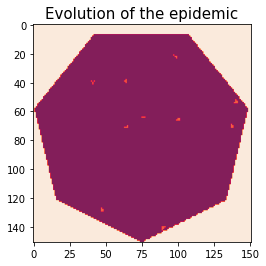

In [16]:
from matplotlib import animation  
import matplotlib.image as mgimg

#set up the figure
fig = plt.figure()
ax = plt.gca()

#initialization of animation, plot array of zeros 
def init():
    imobj.set_data(DF_List[0][0].to_numpy().reshape(population.shape[0],population.shape[1]))

    return  imobj,

def animate(i): # animation of experiment 0 at time i
    imobj.set_data(DF_List[i][0].to_numpy().reshape(population.shape[0],population.shape[1]))

    return  imobj,


## create an AxesImage object
plt.title('Evolution of the epidemic', fontsize=15)
imobj = ax.imshow(DF_List[0][0].to_numpy().reshape(population.shape[0],population.shape[1]), vmin=-1, vmax=2, cmap='rocket')#, origin='lower', alpha=1.0, zorder=1, aspect=1 )

anim = animation.FuncAnimation(fig, animate, init_func=init, repeat = True,
                               frames=range(0,49), interval=200, blit=True, repeat_delay=1000)

In [17]:
HTML(anim.to_html5_video())